## Vehicle Detection and Tracking Project

The goals / steps of this project are the following:

* Decide what feature to use: combination of color and gradient based features.
* Choose and train a classifier: linear SVM...
* Implement a sliding window technique to search for vehicles in some test images: Multiscale search/Different tiling schemes.
* Minimize the number of search windows.
* Do not need to search for cars in the sky and the treetops.
* Output visual display of the vehicle boundaries.

## Import library

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
import numpy as np
import cv2
import glob
import time
from sklearn.utils import shuffle
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from lesson_functions import *
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

import os
from scipy.ndimage.measurements import label

from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Training SGDClassifier

### Read in cars and notcars

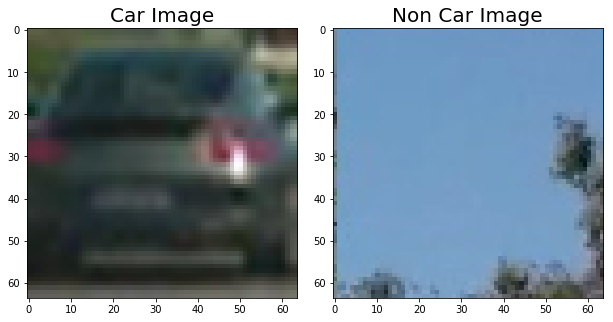

In [3]:
cars = []
notcars = []
for file in os.listdir('dataset/vehicles'):
    cars += glob.glob('dataset/vehicles/'+file+'/*.png')
for file in os.listdir('dataset/non-vehicles'):
    notcars += glob.glob('dataset/non-vehicles/'+file+'/*.png')

# Plot in notebook
image_car = mpimg.imread(cars[0])
image_noncar = mpimg.imread(notcars[0])
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
f.tight_layout()
ax1.imshow(image_car)
ax1.set_title('Car Image', fontsize=20)
ax2.imshow(image_noncar)
ax2.set_title('Non Car Image', fontsize=20)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.)
# Save to local disk
plt.savefig('output_images/car_noncar_image.png')

### Define dataset

In [4]:
# Limit data for test
#cars = cars[:2560]
#notcars = notcars[:2560]

In [50]:
# Check the time
t=time.time()
# Define the paths vector
dataset_paths = np.hstack((cars, notcars))
# Define the labels vector
dataset_labels = np.hstack((np.ones(len(cars)), np.zeros(len(notcars))))
# Define dataset
dataset = np.vstack((dataset_paths, dataset_labels)).T
t2 = time.time()
print(round(t2-t, 2), 'Seconds to Define the dataset...')
print('Dataset size =', dataset.shape)

0.02 Seconds to Define the dataset...
Dataset size = (17760, 2)


### Split up data into randomized training and validation sets

In [51]:
# Check the time
t=time.time()
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
dataset_train, dataset_valid = train_test_split(
    dataset, test_size=0.2, random_state=rand_state)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to Split up data into randomized training and test sets...')
print('Training Dataset size =', dataset_train.shape)
print('Validation Dataset size =', dataset_valid.shape)

0.01 Seconds to Split up data into randomized training and test sets...
Training Dataset size = (14208, 2)
Validation Dataset size = (3552, 2)


In [7]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
X_scaler = None

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')

Using: 9 orientations 8 pixels per cell and 2 cells per block


In [35]:
def generator(dataset, batch_size=1024):

    global X_scaler

    num_samples = len(dataset)

    dataset = shuffle(dataset)
    dataset_paths = dataset.T[0]
    dataset_labels = dataset.T[1]

    for offset in range(0, num_samples, batch_size):

        batch_paths = dataset_paths[offset:offset+batch_size]
        batch_labels = dataset_labels[offset:offset+batch_size].reshape(-1).astype(np.float64)
        batch_id = str(offset//batch_size+1)+'/'+str(int(round(num_samples/batch_size+0.5, 0)))

        # Extract Car/Non-Car features
        dataset_features = extract_features(batch_paths, 
                        batch_id, 
                        color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

        # Create an array stack of feature vectors
        X = np.array(dataset_features, dtype=np.float64)

        # Fit a per-column scaler
        if (X_scaler == None):
            X_scaler = StandardScaler().fit(X)

        # Apply the scaler to X
        scaled_X = X_scaler.transform(X)

        yield shuffle(scaled_X, batch_labels)

In [36]:
### Create training set and validation set
train_generator = generator(dataset_train, batch_size=2048)
validation_generator = generator(dataset_valid, batch_size=2048)

In [10]:
'''
# Check the time
t=time.time()
car_ind = np.random.randint(0, len(cars))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()
t2 = time.time()
print(round(t2-t, 2), 'Seconds to Plot an example of raw and scaled features...')
'''

"\n# Check the time\nt=time.time()\ncar_ind = np.random.randint(0, len(cars))\n# Plot an example of raw and scaled features\nfig = plt.figure(figsize=(12,4))\nplt.subplot(131)\nplt.imshow(mpimg.imread(cars[car_ind]))\nplt.title('Original Image')\nplt.subplot(132)\nplt.plot(X[car_ind])\nplt.title('Raw Features')\nplt.subplot(133)\nplt.plot(scaled_X[car_ind])\nplt.title('Normalized Features')\nfig.tight_layout()\nt2 = time.time()\nprint(round(t2-t, 2), 'Seconds to Plot an example of raw and scaled features...')\n"

### Use SGDClassifier

#### Training

In [11]:
model = SGDClassifier(n_iter=1, verbose=0, n_jobs=4)

# Train model
for feature_gen, label_gen in train_generator:
    model.partial_fit(feature_gen, label_gen, classes=np.unique(label_gen))

Extracting 7: 100%|██████████| 1920/1920 [00:48<00:00, 39.75it/s]


#### Validation

In [37]:
# Check the score of the SGDClassifier
X_valid = []
y_valid = []
for feature_gen, label_gen in validation_generator:
    X_valid.append(feature_gen)
    y_valid.append(label_gen)

Extracting 2/2: 100%|██████████| 1504/1504 [00:23<00:00, 63.69it/s]


In [38]:
X_valid = np.array(X_valid)
num_of_feature = X_valid[0].shape[-1]
X_valid = np.concatenate(X_valid).ravel().reshape(-1, num_of_feature)
y_valid = np.concatenate(y_valid).ravel()
print('X_valid dimention = ', X_valid.shape)
print('y_valid dimention = ', y_valid.shape)
print('Test Accuracy of SGDClassifier = ', round(model.score(X_valid, y_valid), 4))

X_valid dimention =  (3552, 8460)
y_valid dimention =  (3552,)
Test Accuracy of SGDClassifier =  0.9786


#### Check prediction

In [48]:
# Check the prediction time for a single sample
t=time.time()
n_predict = 1000
y_pred = model.predict(X_valid[0:n_predict])
#print('My SGDClassifier predicts:', y_pred)
#print('For these', n_predict, 'labels:      ', y_valid[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SGDClassifier')

accuracy = np.sum(y_pred == y_valid[0:n_predict]) * 100 / n_predict
print("Accuracy = %d%%" % accuracy)

0.01745 Seconds to predict 1000 labels with SGDClassifier
Accuracy = 97%


## Test a Single Sample

### Find cars

In [15]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, model, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):

    box_list = []
    img = img.astype(np.float32)/255

    img_tosearch = img[ystart:ystop,:,:] # [height, width, channel]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    

            test_prediction = model.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box_list.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])

    return box_list

### Test Find Cars function

In [16]:
# Check the prediction time for a single sample
t=time.time()

img = mpimg.imread('test_images/bbox-example-image.jpg')

ystart = 400
ystop = 656
scale = 1.5

box_list = find_cars(img, ystart, ystop, scale, model, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to predict a single sample...')
print('Number of boxlist =', len(box_list))

1.31 Seconds to predict a single sample...
Number of boxlist = 14


### Apply Heat Map

In [17]:
def pipeline_heatmap(img, box_list):

    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)

    return draw_img, heatmap

### Test Heart Map function

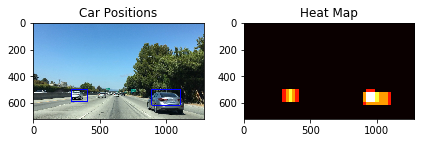

In [18]:
draw_img, heatmap = pipeline_heatmap(img, box_list)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

## Pipeline Detection

In [19]:
def process_image(img):

    ystart = 400
    ystop = 656
    scale = 1.5
    box_list = find_cars(img, ystart, ystop, scale, model, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    draw_img, heatmap = pipeline_heatmap(img, box_list)

    return draw_img

## Test video

In [20]:
video_name = 'test_video.mp4'
output_path = 'output_videos/'
clip1 = VideoFileClip(video_name)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_path+video_name, audio=False)

[MoviePy] >>>> Building video output_videos/test_video.mp4
[MoviePy] Writing video output_videos/test_video.mp4


 97%|█████████▋| 38/39 [00:35<00:00,  1.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/test_video.mp4 

CPU times: user 35.7 s, sys: 200 ms, total: 35.9 s
Wall time: 38.9 s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_path+video_name))

## Project video

In [22]:
video_name = 'project_video.mp4'
output_path = 'output_videos/'
clip1 = VideoFileClip(video_name)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_path+video_name, audio=False)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████▉| 1260/1261 [20:56<00:00,  1.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

CPU times: user 21min 5s, sys: 6.43 s, total: 21min 11s
Wall time: 20min 59s


In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_path+video_name))